In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

### Chain rule and backprop:

#### **1. Multiplication:**

For and intermediate expression say: **o1 = w2 * x2**        or         **(*out = self.data * other.data*)**

If we want the gradient of w2 to evalute its impact over loss L:        or         **(*self.grad*)**

**Chain Rule to evaluate dL/dw2:**

dL/dw2 breaks down to dL/do1 * do1/dw2        or         **(*self.grad = out.grad * do1/dw2*)**

do1/dw2 = d(x2 * w2) / dw2 where x2 is constant 

so do1/dw2 = x2        or         **(*other.data*)**

so dL/dw2 = dL/do1 * x2        or         **(*self.grad = out.grad * other.data*)**


similarly:  **(*other.grad = out.grad * self.data*)**



#### **2. Addition:**

For another intermediate experssion:  **o2 = x1 + x2**      or      **(*out = self.data + self.data*)**

If we want the gradient of x1 to evalute its impact over loss L:        or         **(*self.grad*)** 

**Chain Rule to evaluate dL/dx1:**

dL/dx1 breaks down to dL/do2 * do2/dx1        or         **(*self.grad = out.grad * do2/dx2*)**

do2/dx1 = d(x1 + x2) / dx1 where x2 is constant 

so do2/dx1 = 1.0        or         **(*1.0*)**

so dL/dx1 = dL/do2 * 1.0       or         **(*self.grad = out.grad * 1.0*)**


similarly, **(*other.grad = out.grad * 1.0*)**   


{addition symbol distributes the gradient backward}


#### **3. tanh**

o3 = tanh(x)        or         **(*out = tanh(self.data or value)*)**

if we want to evaluate self.grad:

d/dx tanh x = 1 - tanh^2 x 

    

In [3]:
class Value:
    def __init__(self, data, op = '', children = (), label = None):
        self.data = data
        self._op = op
        self._prev = set(children) #set of previous Value objects that this Value depends on
        self._backward = lambda: None  # default backward function does nothing
        self.label = label
        self.grad = 0.0
    # __repr__ is a special method that defines how the object is represented as a string
    # when you call print on the object or use it in a string context

    def __repr__(self):
        return f"Value(data: {self.data})" 

    # method to add two Value objects
    # this method is called when you use the + operator on two Value objects
    def __add__(self, other):
        
        other = other if isinstance(other, Value) else Value(other)  # ensure other is a Value object
        out = Value(self.data + other.data, op = '+', children = (self, other))\
        # define the backward function for addition

        ##confusing fomatting, but this is a comment 
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        
        out._backward = _backward
        return out
    
    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-1 * other)

    # method to multiply two Value objects
    # this method is called when you use the * operator on two Value objects
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)  # ensure other is a Value object
        out = Value(self.data * other.data, op = '*', children = (self, other))
        # define the backward function for multiplication
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other):
        # fallback method for multiplication
        # this method is called when you use the * operator with a Value object on the right side
        return self.__mul__(other)
    ## rmul swaps the order of operands 2*a to a*2

    def exp(self):
        x = self.data
        out = Value(math.exp(x), op='exp', children=(self,))  ## children of out is self

        def _backward():
            ## differentiation of exp is exp(x)
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "other must be an int or float"
        out = Value(self.data ** other, op='pow', children=(self,))

        # define the backward function for power
        def _backward():
            self.grad += (other * (self.data ** (other - 1))) * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * (other**-1)  # use multiplication for division
    
    def tanh(self):
        value = self.data
        t = (math.exp(2 * value) - 1) / (math.exp(2 * value) + 1)
        out = Value(t, op='tanh', children=(self,))

        # define the backward function for tanh
        def _backward():
            self.grad += (1 - (t ** 2)) * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        # initialize the gradient of the output Value to 1.0
        self.grad = 1.0
        topo = []
        visited = set()

        def trace(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    trace(child)
                topo.append(v)
        
        trace(self)
        for v in reversed(topo):
            v._backward()

In [4]:
a = Value(2.0, label='a')
b = Value(3.0, label='b')
a/b
a - b

Value(data: -1.0)

In [5]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s |data: %.4f| grad: %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [90]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')  # Bias term

x1w1 = x1 * w1  # Multiply x1 and w1
x1w1.label = 'x1 * w1'  # Assigning a label to the result of the multiplication
x2w2 = x2 * w2  # Multiply x2 and w2
x2w2.label = 'x2 * w2'  # Assigning a label to the result of the multiplication
x1w1x2w2 = x1w1 + x2w2  # Add the results of the multiplications
x1w1x2w2.label = 'x1 * w1 + x2 * w2'  # Assigning a label to the result of the addition

n = x1w1x2w2 + b  # Add the bias term
n.label = 'n'  # Assigning a label to the final output
L = n.tanh()  # Apply the tanh activation function
L.label = 'L'  # Assigning a label to the final output after tanh

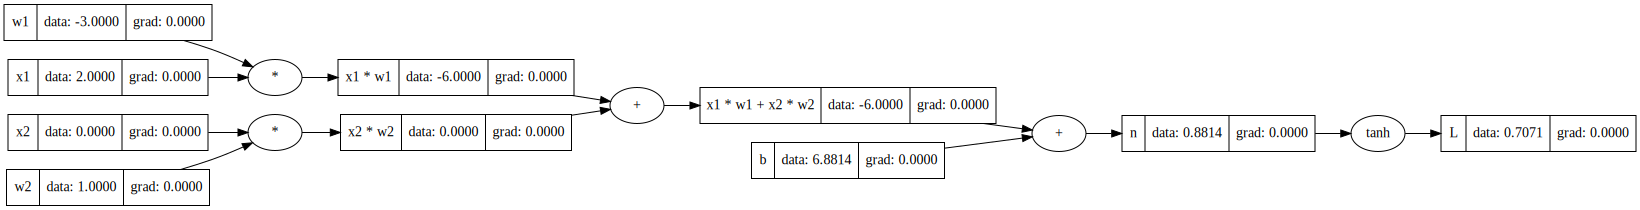

In [91]:
draw_dot(L)

In [59]:

L.grad = 1.0  # Set the gradient of the output to 1.0
L._backward()  #need to set the gradient of the output to 1.0 before calling backward
n._backward()  # Backpropagate through the addition
x1w1x2w2._backward()  # Backpropagate through the addition
x1w1._backward()  # Backpropagate through the multiplication
x2w2._backward()  # Backpropagate through the multiplication

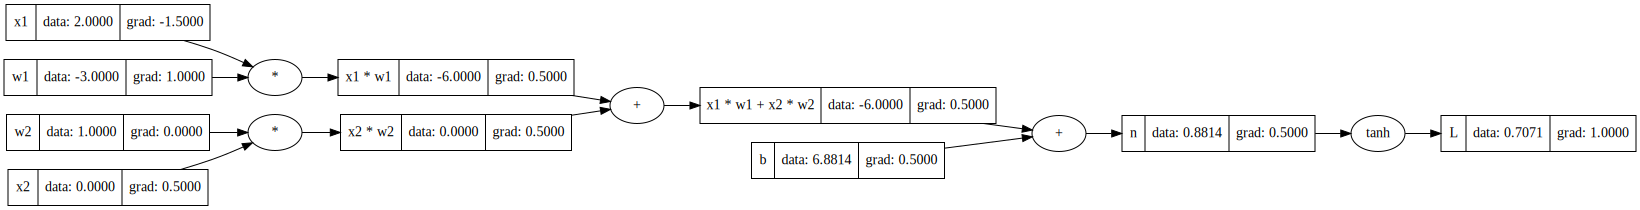

In [60]:
draw_dot(L)

### Backward propagation of gradients:

1. Set L's grad to be 1.0 since dL/dL = 1.

2. Perform topological sort over the expression to get all the children of individual expressions in the topo list.

3. reverse the list and execute ._backward method over the nodes in the list to evalute gradients.

In [86]:
visited = set()
topo = []

def trace_backward(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            #print(f"child: {child.label}, data: {child.data}")
            trace_backward(child)
        topo.append(v)  ## add all the visited nodes to the topo list and append 
            
trace_backward(L)  # Start tracing backward from the output L

for v in reversed(topo):
    L.grad = 1.0
    v._backward()  # Call the backward function for each node in reverse topological order

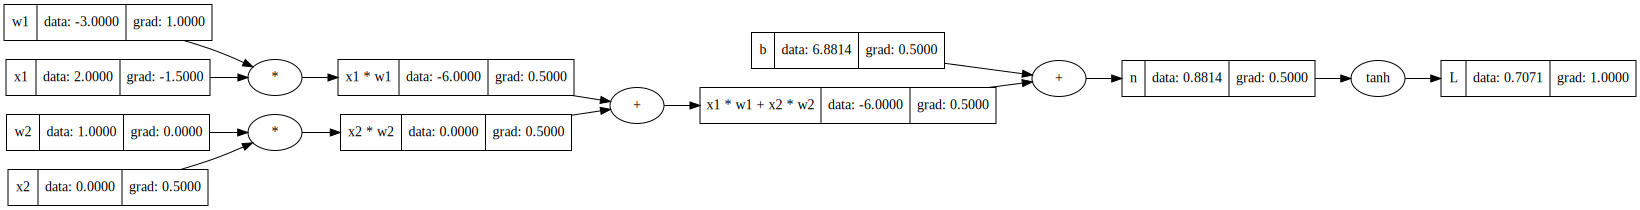

In [87]:
draw_dot(L)

backward call:

In [93]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')  # Bias term

x1w1 = x1 * w1  # Multiply x1 and w1
x1w1.label = 'x1 * w1'  # Assigning a label to the result of the multiplication
x2w2 = x2 * w2  # Multiply x2 and w2
x2w2.label = 'x2 * w2'  # Assigning a label to the result of the multiplication
x1w1x2w2 = x1w1 + x2w2  # Add the results of the multiplications
x1w1x2w2.label = 'x1 * w1 + x2 * w2'  # Assigning a label to the result of the addition

n = x1w1x2w2 + b  # Add the bias term
n.label = 'n'  # Assigning a label to the final output
L = n.tanh()  # Apply the tanh activation function
L.label = 'L'  # Assigning a label to the final output after tanh

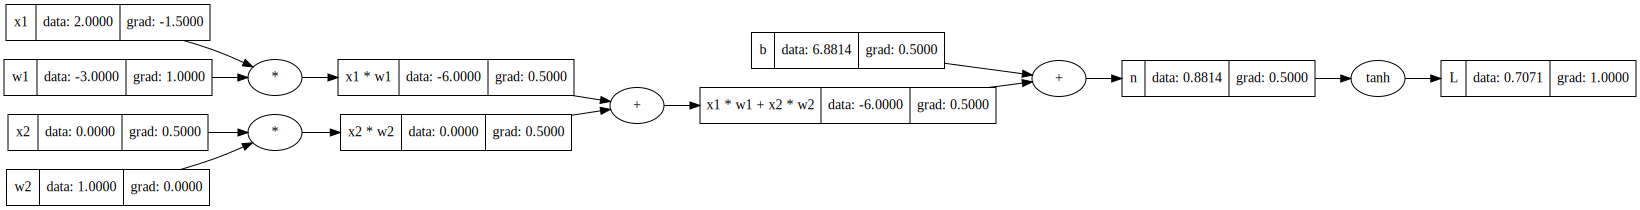

In [94]:
L.backward()  # Call the backward method to compute gradients
draw_dot(L)

Bug in Class Value:

grad for db/da should be: 

b = a + a

db/da = 2.0

but according to code it is 1.0.

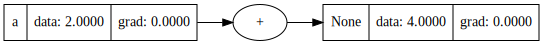

In [98]:
a = Value(2.0, label='a')
b = a + a  # This will create a new Value object with data 4.0
draw_dot(b)

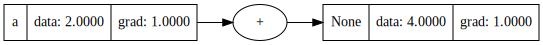

In [99]:
b.backward()  # This will call the backward function for b, which will propagate the gradient to a
draw_dot(b)

### Solution

ACCUMULATE GRADIENTS: add the gradients.

Replace: self.grad = other.data * out.grad with self.grad += other.data * out.grad {everywhere}

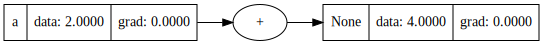

In [101]:
a = Value(2.0, label='a')
b = a + a  # This will create a new Value object with data 4.0
draw_dot(b)

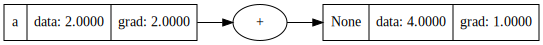

In [102]:
b.backward()  # This will call the backward function for b, which will propagate the gradient to a
draw_dot(b)

Other Issues

In [105]:
a = Value(2.0, label='a')
a + 2

Value(data: 4.0)

In [108]:
a = Value(2.0, label='a')
a * 2

Value(data: 4.0)

In [ ]:
#what about 2 * a?
a = Value(2.0, label='a')
2 * a  # This will create a new Value object with data 4.0
## a.__mul__(2)  and 2.__mul__(a) are two different ways to call the multiplication operator
## using rmul() allows the second operand to be a Value object
## rmul is a special method that is called when the left operand is not a Value object
## acts as a fallback for the multiplication operator when the left operand is not a Value object

TypeError: unsupported operand type(s) for *: 'int' and 'Value'

In [ ]:
a = Value(2.0, label='a')
2 * a 


Value(data: 4.0)

In [116]:
## exp
a = Value(2.0, label='a')
b = a.exp()  # This will create a new Value object with data exp(2.0)
b

Value(data: 7.38905609893065)

### Breaking down tanh

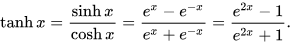

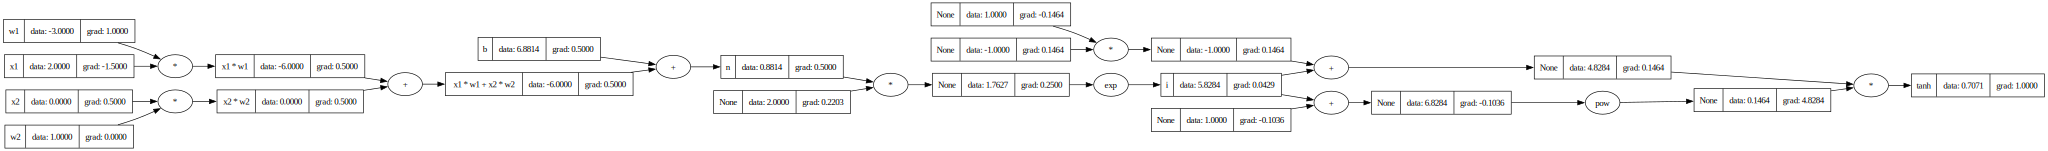

In [7]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')  # Bias term

x1w1 = x1 * w1  # Multiply x1 and w1
x1w1.label = 'x1 * w1'  # Assigning a label to the result of the multiplication
x2w2 = x2 * w2  # Multiply x2 and w2
x2w2.label = 'x2 * w2'  # Assigning a label to the result of the multiplication
x1w1x2w2 = x1w1 + x2w2  # Add the results of the multiplications
x1w1x2w2.label = 'x1 * w1 + x2 * w2'  # Assigning a label to the result of the addition

n = x1w1x2w2 + b  # Add the bias term
n.label = 'n'  # Assigning a label to the final output

i = (2*n).exp()  # Apply the exp function to the output n
i.label = 'i'  # Assigning a label to the output of the exp function
t = (i - 1) / (i + 1)  # Apply the tanh function to the output of the exp function
t.label = 'tanh'  # Assigning a label to the output of the tanh function
t.backward()  # Call the backward method to compute gradients
draw_dot(t)  # Draw the computation graph for the tanh function